In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables, split_train_cal_test
import os
import matplotlib.pyplot as plt

In [3]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
df_init = pd.read_csv(f_path, na_values="None")
df_init = df_init.replace(to_replace=' ', value=np.nan)
df_init = recode_variables(df_init)

In [ ]:
df = df_init.copy()
df.dropna(inplace=True)

df = df.sample(n = 1000)
ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']

X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]

outcome = 'Waist'
y = df[[outcome]]
y = y[outcome].astype(float)

In [6]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

alpha = 0.05
n_resamplings = 25

all_data = pd.DataFrame()

no_cal_cov = []
cp_cov = []

alphas = [0.2, 0.1, 0.05, 0.01]
alphas.reverse()

for alpha in alphas:
    for i in range(n_resamplings):
        df = df_init.copy()
        df.dropna(inplace=True)
        
        df = df.sample(n = 10000)
        X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]
        
        outcome = 'Waist'
        y = df[[outcome]]
        y = y[outcome].astype(float)

        X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)
    
        reg = CP(X_train, X_cal, y_train, y_cal, alpha=alpha, regressor="QR", verbose=0)
        reg.train()
        reg.calc_qhat()
        cp_df = reg.predict_cp_quantiles(X_test, y_test)
        no_cp_df = reg.predict_mdl_quantiles(X_test, y_true= y_test)
        
        cov_no_cal = calc_coverage(no_cp_df)
        cov = calc_coverage(cp_df)
        
        no_cal_cov.append(cov_no_cal)
        cp_cov.append(cov)
        
        tmp_dict = {'alpha': alpha,
                    'cp': True,
                    'coverage': cov}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        tmp_dict = {'alpha': alpha,
                    'cp': False,
                    'coverage': cov_no_cal}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        
        print(f"{i}: no-cp: {cov_no_cal}, cp: {cov}")

0: no-cp: 0.9892, cp: 0.986
1: no-cp: 0.9868, cp: 0.988
2: no-cp: 0.9888, cp: 0.9892
3: no-cp: 0.9948, cp: 0.9944
4: no-cp: 0.9872, cp: 0.99
5: no-cp: 0.99, cp: 0.9912
6: no-cp: 0.98, cp: 0.9796
7: no-cp: 0.9916, cp: 0.99
8: no-cp: 0.992, cp: 0.9928
9: no-cp: 0.9912, cp: 0.9908
10: no-cp: 0.9896, cp: 0.9904
11: no-cp: 0.9876, cp: 0.9892
12: no-cp: 0.9868, cp: 0.9896
13: no-cp: 0.9864, cp: 0.9904
14: no-cp: 0.9876, cp: 0.9912
15: no-cp: 0.9892, cp: 0.9908
16: no-cp: 0.9872, cp: 0.9908
17: no-cp: 0.986, cp: 0.9904
18: no-cp: 0.9896, cp: 0.9904
19: no-cp: 0.9868, cp: 0.992
20: no-cp: 0.9908, cp: 0.9928
21: no-cp: 0.9924, cp: 0.9944
22: no-cp: 0.988, cp: 0.988
23: no-cp: 0.99, cp: 0.9924
24: no-cp: 0.9884, cp: 0.988
0: no-cp: 0.9484, cp: 0.946
1: no-cp: 0.9572, cp: 0.9584
2: no-cp: 0.9476, cp: 0.954
3: no-cp: 0.9544, cp: 0.9604
4: no-cp: 0.9508, cp: 0.9532
5: no-cp: 0.948, cp: 0.9592
6: no-cp: 0.9456, cp: 0.9432
7: no-cp: 0.9456, cp: 0.9532
8: no-cp: 0.9536, cp: 0.962
9: no-cp: 0.9484, cp:

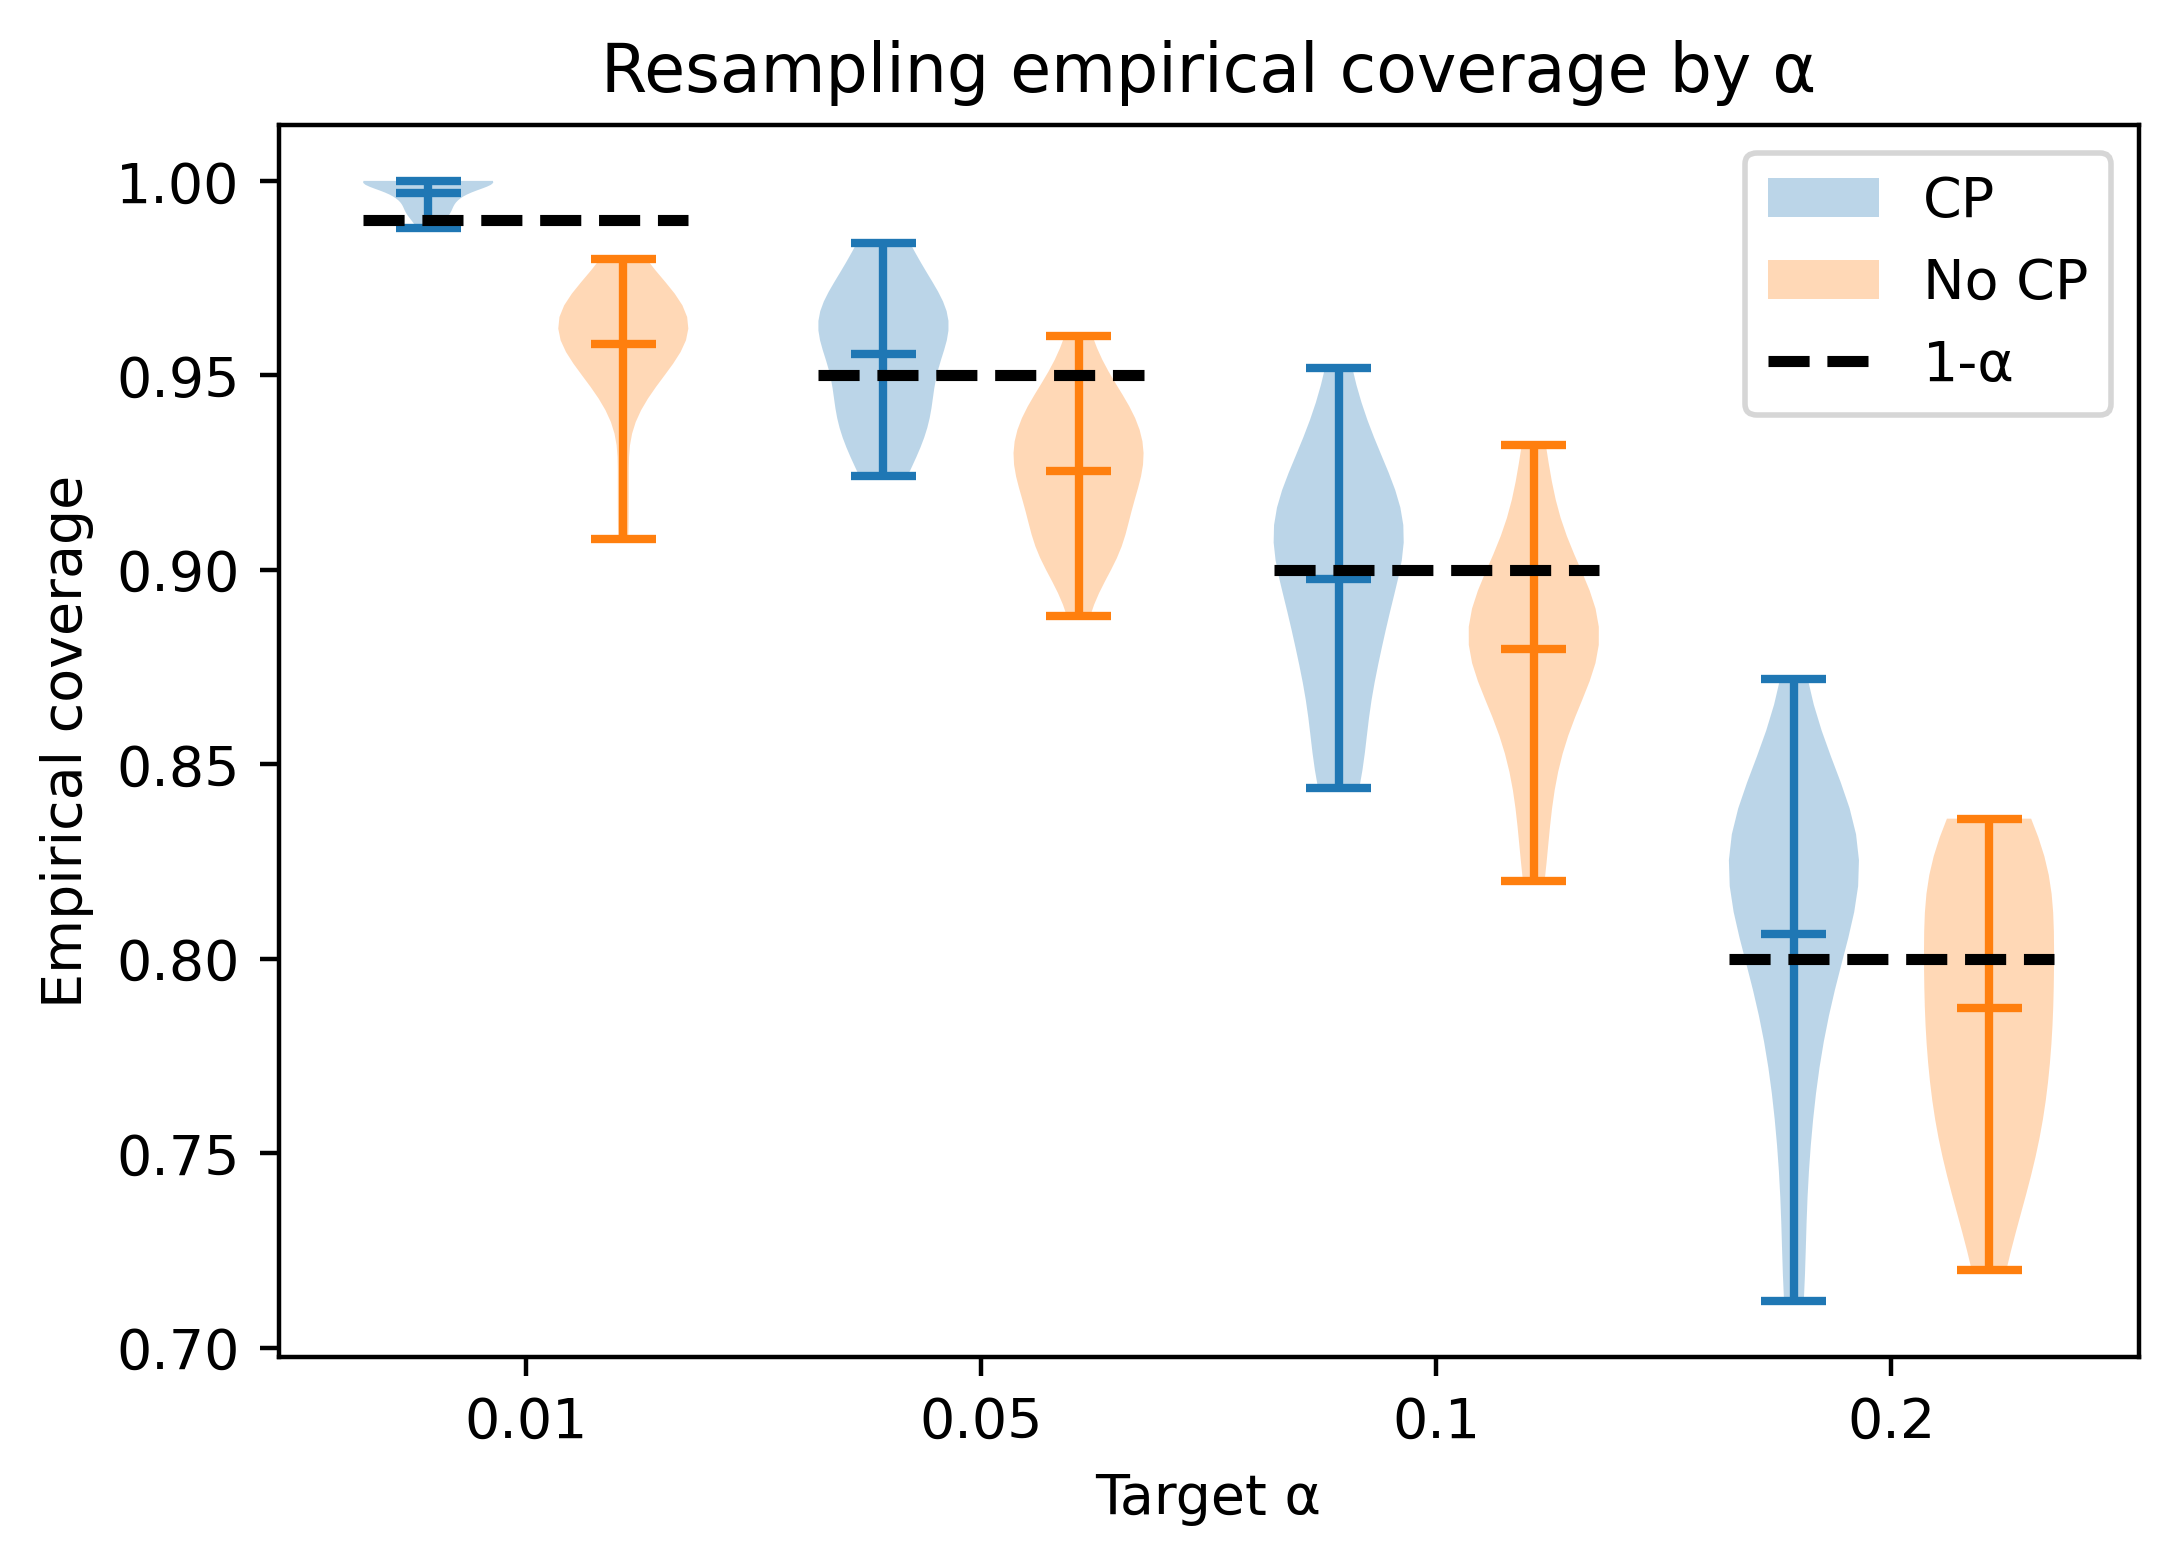

In [5]:
plt.hist(cp_cov, bins=10, color='blue', alpha=0.75)
plt.axvline(x=np.mean(cp_cov), color='b', linewidth=3)
plt.hist(no_cal_cov, bins=10, alpha=0.5, color='orange')
plt.axvline(x=np.mean(no_cal_cov), color='orange', linewidth=3)
plt.axvline(x=1-alpha, color='r', linewidth=3)
plt.show()

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
cp_data = all_data[all_data['cp'] == 1]
unique_vals = []
for alpha in alphas:
    is_curr = cp_data[cp_data['alpha'] == alpha]
    unique_vals.append(is_curr['coverage'])
v1 = plt.violinplot(dataset=unique_vals, positions=np.arange(1, len(alphas)*1.75, 1.75), showmeans=True, points=n_resamplings)

cp_data = all_data[all_data['cp'] == 0]
unique_vals = []
for alpha in alphas:
    is_curr = cp_data[cp_data['alpha'] == alpha]
    unique_vals.append(is_curr['coverage'])
v2 = plt.violinplot(dataset=unique_vals, positions=np.arange(1.75, len(alphas)*1.75+1, 1.75), showmeans=True, points=n_resamplings)

x_starts = np.arange(0.75, len(alphas)*1.75, 1.75) 
x_stops = np.arange(2, len(alphas)*1.75+1, 1.75) 

for i, alpha in enumerate(alphas):
    p = plt.plot([x_starts[i], x_stops[i]], [1-alpha, 1-alpha], color='black', linewidth=2, linestyle="--")

plt.legend([v1["bodies"][0], v2["bodies"][0], p[0]], ["CP", "No CP", "1-α"])
plt.xticks((x_starts + x_stops)/2, labels=map(str, alphas))
plt.title("Resampling empirical coverage by α")
plt.xlabel("Target α")
plt.ylabel("Empirical coverage")
img_path = os.path.join(plots_folder, "resampling_coverage_across_alpha_OF.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

alpha = 0.05
n_resamplings = 25

all_data = pd.DataFrame()

no_cal_cov = []
cp_cov = []

models = ["QR", "GBR", "NN"]

for model in models:
    for i in range(n_resamplings):
        df = df_init.copy()
        df.dropna(inplace=True)
        
        df = df.sample(n = 5000)
        ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
        eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']
        
        X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]
        
        outcome = 'Waist'
        y = df[[outcome]]
        y = y[outcome].astype(float)

        X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)
    
        reg = CP(X_train, X_cal, y_train, y_cal, alpha=alpha, regressor=model, verbose=0)
        reg.train()
        reg.calc_qhat()
        cp_df = reg.predict_cp_quantiles(X_test, y_test)
        no_cp_df = reg.predict_mdl_quantiles(X_test, y_true= y_test)
        
        cov_no_cal = np.mean(cp_df['diff'])#calc_coverage(no_cp_df)
        cov = np.mean(cp_df['diff'])#calc_coverage(cp_df)
        
        no_cal_cov.append(cov_no_cal)
        cp_cov.append(cov)
        
        tmp_dict = {'model': model,
                    'cp': True,
                    'coverage': cov}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        tmp_dict = {'model': model,
                    'cp': False,
                    'coverage': cov_no_cal}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        
        print(f"{i}: no-cp: {cov_no_cal}, cp: {cov}")

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
cp_data = all_data[all_data['cp'] == 1]
unique_vals = []
for model in models:
    is_curr = cp_data[cp_data['model'] == model]
    unique_vals.append(is_curr['coverage'])
v1 = plt.violinplot(dataset=unique_vals, positions=np.arange(1, len(models)*1.75, 1.75), showmeans=True, points=n_resamplings)

cp_data = all_data[all_data['cp'] == 0]
unique_vals = []
for model in models:
    is_curr = cp_data[cp_data['model'] == model]
    unique_vals.append(is_curr['coverage'])
v2 = plt.violinplot(dataset=unique_vals, positions=np.arange(1.75, len(models)*1.75+1, 1.75), showmeans=True, points=n_resamplings)

x_starts = np.arange(0.75, len(models)*1.75, 1.75) 
x_stops = np.arange(2, len(models)*1.75+1, 1.75) 

# for i, alpha in enumerate(models):
#     p = plt.plot([x_starts[i], x_stops[i]], [1-alpha, 1-alpha], color='black', linewidth=2, linestyle="--")

# plt.legend([v1["bodies"][0], v2["bodies"][0], p[0]], ["CP", "No CP", "1-α"])
plt.xticks((x_starts + x_stops)/2, labels=map(str, models))
plt.title("Resampling empirical coverage by α")
plt.xlabel("Target α")
plt.ylabel("Empirical coverage")
img_path = os.path.join(plots_folder, "resampling_coverage_across_alpha_OF.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()